In [1]:
import os
import glob as gb
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pickle
from PIL import Image
import cv2


from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [2]:
# Assign path for dataset
TRAIN_DIR = 'eINTERFACE_2021_Image/train'
TEST_DIR = 'eINTERFACE_2021_Image/test'
VAL_DIR = 'eINTERFACE_2021_Image/val'
BATCH_SIZE = 64

In [3]:
# Check number of positions and images for each category
for folder in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname = f'{TRAIN_DIR}/{folder}/*.jpg')
    print(f'Folder train data, found {len(files)} in folder {folder}')

print('--------------------------------------------------')

# Check number of positions and images for each category
for folder in os.listdir(TEST_DIR):
    files = gb.glob(pathname = f'{TEST_DIR}/{folder}/*.jpg')
    print(f'Folder test data, found {len(files)} in folder {folder}')

Folder train data, found 1896 in folder Anger
Folder train data, found 1891 in folder Disgust
Folder train data, found 1922 in folder Fear
Folder train data, found 1922 in folder Happiness
Folder train data, found 1922 in folder Sadness
Folder train data, found 1922 in folder Surprise
--------------------------------------------------
Folder test data, found 237 in folder Anger
Folder test data, found 237 in folder Disgust
Folder test data, found 241 in folder Fear
Folder test data, found 241 in folder Happiness
Folder test data, found 241 in folder Sadness
Folder test data, found 241 in folder Surprise


In [4]:
def view_random_image(target_dir, target_class):
    # Path of random image
    target_folder = target_dir + '/' + target_class

    random_image = random.sample(os.listdir(target_folder), 1)

    # Read and plot image
    img = mpimg.imread(f'{target_folder}/{random_image[0]}')
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    print(f'Image shape: {img.shape}')

    return img

Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)
Image shape: (416, 416, 3)


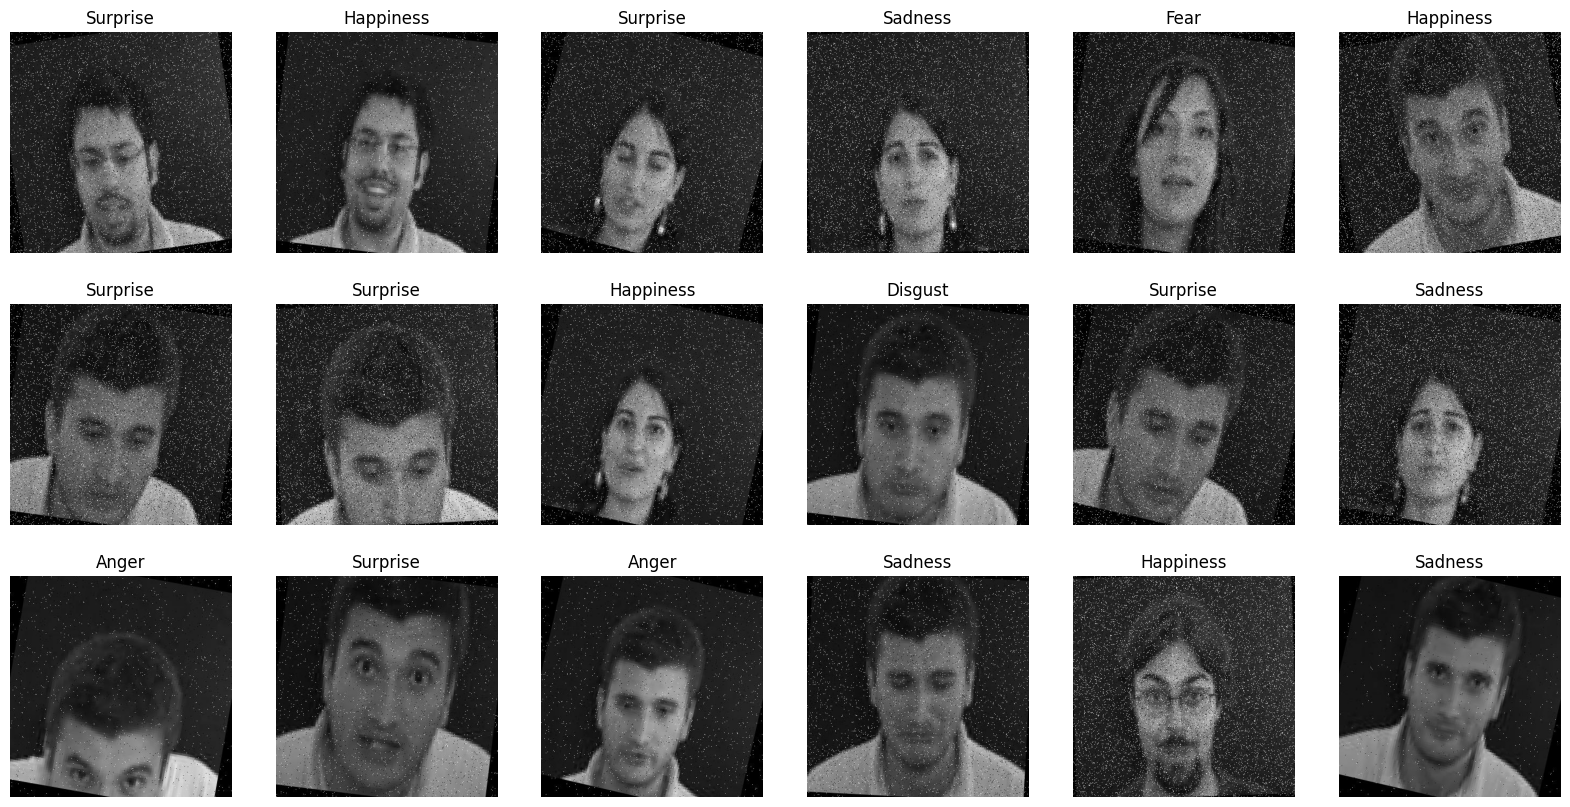

In [5]:
class_names = os.listdir(TRAIN_DIR)

plt.figure(figsize= (20,10))
for i in range(18):
    plt.subplot(3, 6, i + 1)
    class_name = random.choice(class_names)
    img = view_random_image(target_dir= TRAIN_DIR, target_class = class_name)

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)
train_set = train_data_gen.flow_from_directory(TRAIN_DIR,
                                               target_size = (128,128),
                                               batch_size = BATCH_SIZE,
                                               class_mode = 'categorical')

test_data_gen = ImageDataGenerator(rescale = 1./255)
test_set = test_data_gen.flow_from_directory(TEST_DIR,
                                             target_size = (128,128),
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')

Found 11475 images belonging to 6 classes.
Found 1438 images belonging to 6 classes.


In [7]:
classifier = Sequential([
    Conv2D(16, (3,3), input_shape= (128,128,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(32, (2,2), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (2,2), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (2,2), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=6, activation = 'softmax')           
])

classifier.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [8]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

In [ ]:
history = classifier.fit(train_set,
                         epochs=50,
                         validation_data=test_set)

In [24]:
model_classifier = pickle.load(open('emotion_classifier_model.pkl', 'rb'))

def random_path_picker(target_dir, target_classes):

    random_class = random.choice(target_classes)

    # Path of random image
    target_folder = target_dir + '/' + random_class
    random_image = random.sample(os.listdir(target_folder), 1)

    return f'{target_folder}/{random_image[0]}'

def image_preprocessor(path):

    image = cv2.imread(path)
    image_from_array = Image.fromarray(image, 'RGB')
    resize_image= image_from_array.resize((128, 128))
    expand_input = np.expand_dims(resize_image, axis = 0)
    input_data  = np.array(expand_input)
    input_data = input_data/255

    return input_data

def classification_class(dict_classes, prediction_result):
    for key in dict_classes:
        if dict_classes[key] == prediction_result:
            return key
        
def predict(model, input_data):
    pred = model.predict(input_data)
    result = pred.argmax()
    return classification_class(train_set.class_indices, result)

def show_image(path):
    img = Image.open(path)
    plt.imshow(img)
    plt.title(path.split('/')[2])
    plt.axis('off')


In [41]:
random_path = random_path_picker(VAL_DIR, os.listdir(VAL_DIR))
image = image_preprocessor(random_path)
pred = predict(model_classifier, image)
pred

1/1 [==============================] - 0s 21ms/step


'Happiness'

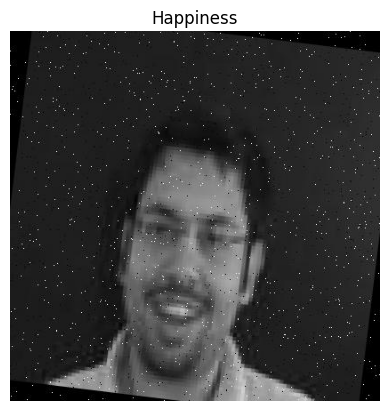

In [42]:
show_image(random_path)